## `Speculator`: tau, Z, Dust

`speculator` takes physical parameters and predict PCA coeffs, spectra, and also magnitudes. 

This notebook takes code from `speculator`: https://github.com/justinalsing/speculator`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import astropy.units as u
# import kuaizi
import torch
from torch import Tensor

In [3]:
import os
os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')

In [4]:
# kuaizi.set_matplotlib(style='nature', usetex=False)
# kuaizi.set_env(project='popsed', name='', data_dir='/scratch/gpfs/jiaxuanl/Data')

In [5]:
import sys
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.speculator import Speculator, interp_nan

In [6]:
params = np.concatenate([np.load(f'./train_sed/fsps.TZD.v0.1.theta.seed{i+1}.npy')
                         for i in range(5)])
params[:, 1] = np.log10(params[:, 1]) # tau to log(tau)
params = params[:, :4] # exclude stellar mass (1 M_\dot) and redshift (z=0.0)

In [7]:
log_spec = np.concatenate([np.load(f'./train_sed/fsps.TZD.v0.1.log10spectrum.seed{i+1}.npy')
                           for i in range(5)])
log_spec = interp_nan(log_spec)[:, 500:]
# Very large... and slow

In [8]:
zero_flag = (np.mean(log_spec, axis=1) < -30)

log_spec = log_spec[~zero_flag]
params = params[~zero_flag]
pca_coeff = np.load('./train_sed/fsps.pca_coeffs.npy')[~zero_flag]
# # This zero_flag is SUPER IMPORTANT!!!

In [9]:
pca_coeff.shape

(49522, 50)

`params: tage, log tau, logzsol, dust2`

In [10]:
dlambda_spec = 2
wave_lo = 2000 # 1000
wave_hi = 15000
wavelengths = np.arange(wave_lo, wave_hi, dlambda_spec)

In [11]:
speculator = Speculator(name='TZD', n_parameters=4,
                        pca_filename='./train_sed/fsps_pca_trained_TZD.pkl', 
                        hidden_size=[128, 256, 256, 256])

In [12]:
speculator.load_data(pca_coeff, params, 
                     params_name=['tage', 'logtau', 'logzsol', 'dust2'],
                     val_frac=0.1, batch_size=256, 
                     wave_rest=torch.arange(wave_lo, wave_hi, dlambda_spec), 
                     wave_obs=torch.arange(wave_lo, wave_hi, dlambda_spec))

train_ind = speculator.dataloaders['train'].dataset.indices
val_ind = speculator.dataloaders['val'].dataset.indices

In [14]:
%%time
n_ep = [200, 200, 100] # 500
for i, lr in enumerate([2e-3, 1e-3, 8e-4]): # 3e-4
    speculator.train(learning_rate=lr, n_epochs=n_ep[i])

Loss = 0.00007 (train): 100%|█████████████████████████████████████████████████████████| 200/200 [04:27<00:00,  1.34s/epochs]


Epoch: 202 - val Train Loss: 0.0001
Epoch: 202 - val Vali Loss: 0.0006
Recon error: tensor(0.0054, device='cuda:0', grad_fn=<NanmedianBackward0>)


Loss = 0.00004 (train): 100%|█████████████████████████████████████████████████████████| 200/200 [04:22<00:00,  1.31s/epochs]


Epoch: 402 - val Train Loss: 0.0000
Epoch: 402 - val Vali Loss: 0.0003
Recon error: tensor(0.0037, device='cuda:0', grad_fn=<NanmedianBackward0>)


Loss = 0.00002 (train): 100%|█████████████████████████████████████████████████████████| 100/100 [02:10<00:00,  1.30s/epochs]

Epoch: 502 - val Train Loss: 0.0000
Epoch: 502 - val Vali Loss: 0.0002
Recon error: tensor(0.0022, device='cuda:0', grad_fn=<NanmedianBackward0>)
CPU times: user 10min 39s, sys: 9.41 s, total: 10min 48s
Wall time: 11min


In [24]:
speculator.train(learning_rate=1e-3, n_epochs=50)

Loss = 0.00004 (train): 100%|███████████████████████████████████████| 50/50 [00:52<00:00,  1.05s/epochs]

Epoch: 550 - val Train Loss: 0.0000
Epoch: 550 - val Vali Loss: 0.0003
Recon error: tensor(0.0024, device='cuda:0', grad_fn=<NanmedianBackward0>)


In [98]:
# %%time
# # n_ep = [100, 100, 150, 500, 500]
# # for i, lr in enumerate([2e-3, 1e-3, 5e-4, 3e-4, 1e-4]):
# n_ep = [200, 200, 200, 200, 200]
# for i, lr in enumerate([2e-3, 1e-3, 5e-4, 3e-4, 2e-4]):
#     speculator.train(learning_rate=lr, n_epochs=n_ep[i])

In [15]:
speculator.best_recon_err_epoch

424

In [16]:
speculator.best_loss_epoch

476

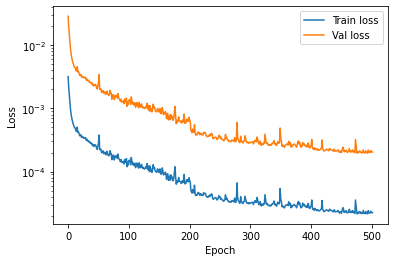

In [17]:
speculator.plot_loss()

In [30]:
## Load the NN emulator `speculator`
with open('./speculator_best_recon_model_TZD.pkl', 'rb') as f:
    speculator = pickle.load(f)

In [31]:
_specs = speculator.predict_spec(torch.Tensor(params[val_ind]).to('cuda')).cpu().detach().numpy()

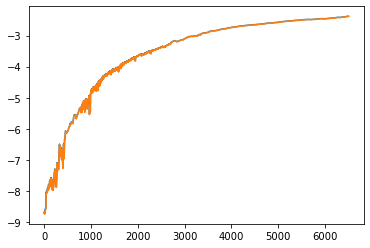

In [32]:
plt.plot(np.log10(_specs)[3019])
plt.plot(log_spec[val_ind][3019])

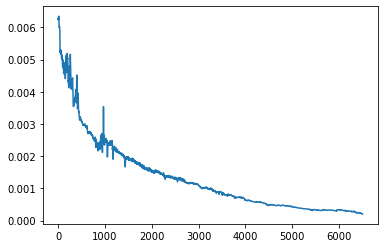

In [33]:
plt.plot(np.nanmedian(np.log10(_specs) - log_spec[val_ind], axis=0))

In [34]:
diff = (10**log_spec[val_ind] - _specs) / 10**log_spec[val_ind] * 100

In [35]:
from scipy.stats import norm

In [36]:
np.where(np.nanmean(diff, axis=1) > 5)

(array([ 210,  383,  511,  854,  939, 1198, 1209, 1380, 1683, 1919, 1979,
        1997, 2151, 2399, 2401, 2516, 2529, 2729, 2796, 2900, 3143, 3330,
        3454, 3484, 3571, 3655, 3711, 3789, 3909, 4006, 4024, 4827]),)

(200.0, 1100.0)

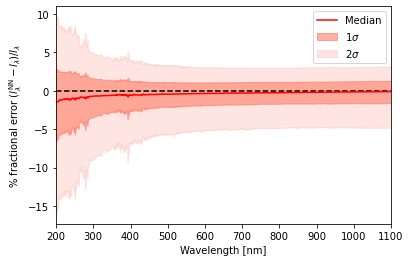

In [37]:
x = wavelengths / 10
plt.plot(x, np.nanmedian(diff, axis=0), color='r', label='Median')
plt.fill_between(x, 
                 np.nanpercentile(diff, (1 - norm.cdf(1)) * 100, axis=0), 
                 np.nanpercentile(diff, norm.cdf(1) * 100, axis=0), alpha=0.5, color='tomato', label=r'$1\sigma$')

plt.fill_between(x, 
                 np.nanpercentile(diff, (1 - norm.cdf(2)) * 100, axis=0), 
                 np.nanpercentile(diff, norm.cdf(2) * 100, axis=0), alpha=0.2, color='salmon', label=r'$2\sigma$')

#plt.ylim(-0.008, 0.008)

plt.ylabel(r'% fractional error $(l_{\lambda}^{\mathrm{NN}} - l_{\lambda})/l_{\lambda}$')
plt.xlabel('Wavelength [nm]')

plt.hlines(0, 200, 1100, ls='--', color='k')
plt.legend()

plt.xlim(200, 1100)